In [50]:
%load_ext dotenv
%dotenv ../../src/.env

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [51]:
import sys
sys.path.append("../../src")

In [52]:
from utils.logger import get_logger
_logs = get_logger(__name__)

In [53]:
import os
from glob import glob

In [54]:
import random

data_files = glob(os.path.join(os.getenv('SRC_DIR'), "processed/*.csv"))

In [55]:
data_files

['../../data/processed\\01_ticker_features.csv',
 '../../data/processed\\02_time_series_dataset.csv',
 '../../data/processed\\03_clustered_dataset.csv']

In [75]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns  
import joblib

In [57]:
clustered_tickers=pd.read_csv(data_files[2])

In [58]:
clustered_tickers['cluster'].value_counts()

cluster
0    433
1     10
2      4
Name: count, dtype: int64

In [59]:
cluster_num=0

In [60]:
df=pd.read_csv(data_files[1]).merge(clustered_tickers, on='ticker', how='inner')

In [61]:
data = df[df['cluster'] == cluster_num].drop(columns=['cluster'])

In [62]:
data.columns

Index(['date', 'ticker', 'open', 'close', 'low', 'high', 'volume',
       'return_pct', 'vol_5d', 'vol_10d', 'momentum_5d', 'momentum_10d',
       'sma_5d', 'sma_10d', 'hl_range_pct', 'oc_change_pct', 'avg_volume_5d',
       'avg_volume_10d'],
      dtype='object')

In [63]:
data.shape

(736245, 18)

In [64]:
data['date'] = pd.to_datetime(data['date'])

In [65]:
data = data.sort_values(['ticker', 'date'])

In [66]:
data.isna().sum()

date              0
ticker            0
open              0
close             0
low               0
high              0
volume            0
return_pct        0
vol_5d            0
vol_10d           0
momentum_5d       0
momentum_10d      0
sma_5d            0
sma_10d           0
hl_range_pct      0
oc_change_pct     0
avg_volume_5d     0
avg_volume_10d    0
dtype: int64

In [67]:
cutoff_date='2016-01-01'

In [68]:
train_data = data[data['date'] < cutoff_date].copy()
test_data  = data[data['date'] >= cutoff_date].copy()

In [69]:
print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)

Train shape: (627130, 18)
Test shape: (109115, 18)


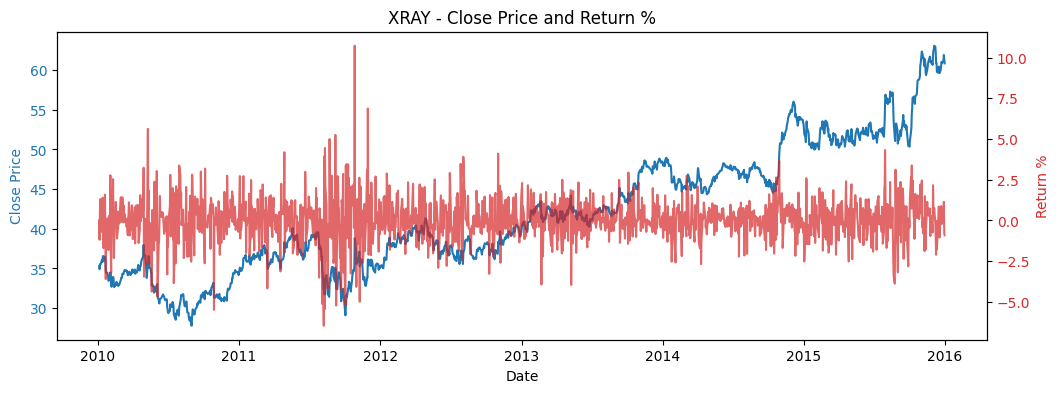

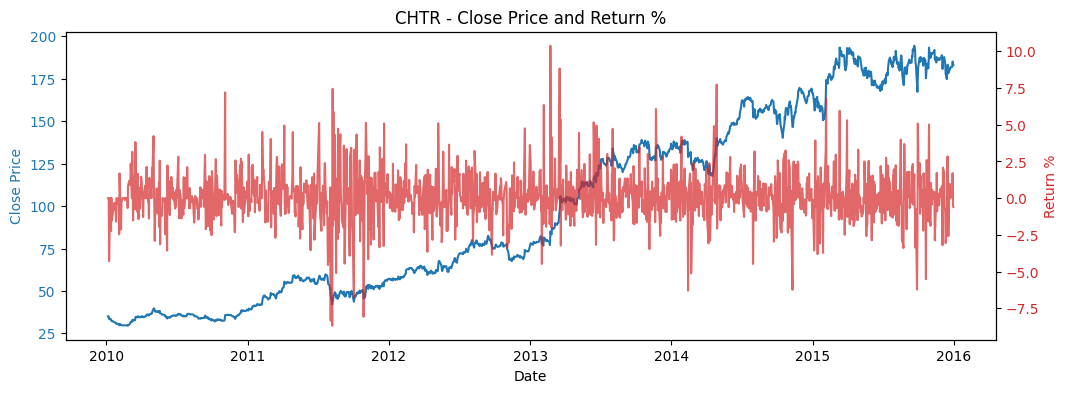

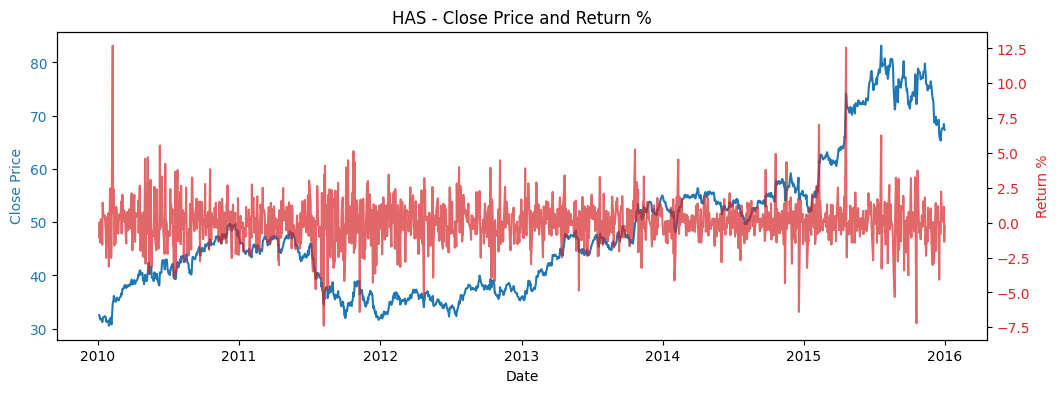

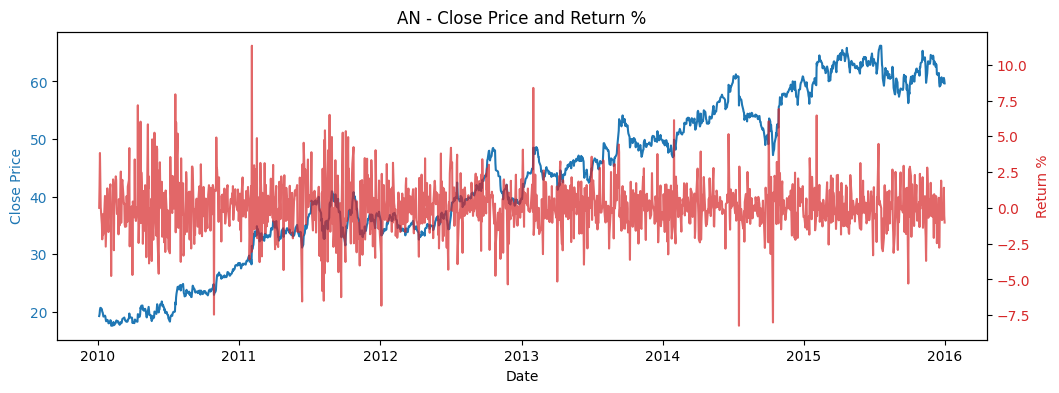

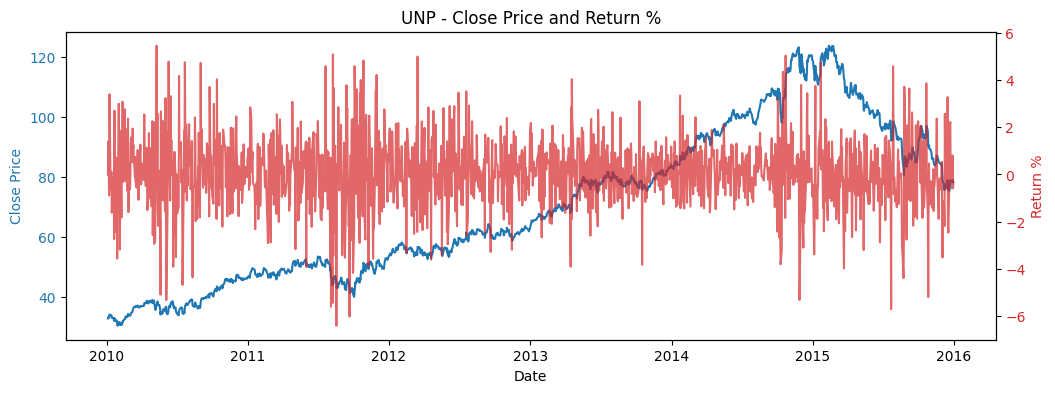

In [70]:
np.random.seed(42)
sample_tickers = np.random.choice(train_data['ticker'].unique(), size=5, replace=False)

# Plot each stock's close price and return_pct
for ticker in sample_tickers:
    df_stock = train_data[train_data['ticker'] == ticker].sort_values('date')
    
    fig, ax1 = plt.subplots(figsize=(12, 4))

    color = 'tab:blue'
    ax1.set_title(f"{ticker} - Close Price and Return %")
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Close Price', color=color)
    ax1.plot(df_stock['date'], df_stock['close'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Return %', color=color)
    ax2.plot(df_stock['date'], df_stock['return_pct'], color=color, alpha=0.7)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.show()

***1. Naive Forecast***
- *Predict return_pct of day t as same as day t-1*
- *Evaluate using RMSE or MAPE per ticker*

In [71]:
train_data['return_pred_naive'] = train_data.groupby('ticker')['return_pct'].shift(1)
test_data['return_pred_naive']  = test_data.groupby('ticker')['return_pct'].shift(1)

In [73]:
# Fill initial NaNs (first day per ticker) with 0 or drop them
train_data = train_data.dropna(subset=['return_pred_naive'])
test_data  = test_data.dropna(subset=['return_pred_naive'])

In [76]:
# Compute error metrics on return_pct
mae_train = mean_absolute_error(train_data['return_pct'], train_data['return_pred_naive'])
mse_train = mean_squared_error(train_data['return_pct'], train_data['return_pred_naive'])


In [77]:
mae_test = mean_absolute_error(test_data['return_pct'], test_data['return_pred_naive'])
mse_test = mean_squared_error(test_data['return_pct'], test_data['return_pred_naive'])

In [78]:
print("Train MAE:", mae_train, "MSE:", mse_train)
print("Test MAE:", mae_test, "MSE:", mse_test)

Train MAE: 1.759515123054092 MSE: 6.386899952991693
Test MAE: 1.8184833824649005 MSE: 7.9640639542148355
